<a href="https://colab.research.google.com/github/kinbtc/nathapon-udomlertsakul/blob/main/ImpermanentLoss_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Simulate trade where the reserve remain unchanged

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

R_0 = [1000000,1000000]
R_d =[0,0]
gamma_fee = 0.999

def price(R_0):
    return R_0[1]/R_0[0]

def plain_swap(x,R_0):
    return (x*R_0[1])/(x+R_0[0])

def swap_fee1(x,R_0):
    return [(gamma_fee*x*R_0[1])/(gamma_fee*x+R_0[0]),(1-gamma_fee)*x]

def swap_fee2(x,R_0):
    # get swap_fee1(x,R_0)[0], but the trade liquidity lose (x*R_0[1])/(x+R_0[0])
    return [swap_fee1(x,R_0)[0],plain_swap(x,R_0) -swap_fee1(x,R_0)[0]]

def new_reserve(R,tender,received):
  R[0] = R[0] + tender
  R[1] = R[1] - received
  return R


#test volumn $1,000 back and forth without changing trading reserve.
def Init_trade_test_asset0fee(tender_basket,R_0,trade_num):
    for i in range(trade_num):
        y = swap_fee1(tender_basket,R_0)
        R_d[0] += y[1]
        R_0 = new_reserve(R_0,gamma_fee*tender_basket,y[0]) #y[0]=receive
        x = swap_fee2(y[0],R_0[::-1])
        R_d[0] +=  x[1]
        R_0 = new_reserve(R_0,-(x[0]+x[1]),-y[0]) #y[0]=tender
    return [R_0,R_d]






### Price function is increasing function.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

R_0 = [1000000,1000000]
R_d =[0,0]
Binance_price = 1 # R[1]/R[0]=1.2 price of asset1 in unit of asset2 = |2|/|1|

def root(y,f):
  epsilon=1e-5
  iteration = 0
  a = -1
  b = 1000000
  while (b - a) / 2 > epsilon and iteration < 100:
    c = (a + b) / 2  # Midpoint
    if f(c)-y == 0:    # We've found the root
        return c
    elif (f(a)-y) * (f(c)-y) < 0:
        b = c
    else:
        a = c
    iteration += 1
  return (a + b) / 2

def price_after_swap(x): #increasing function (asset2 -> asset1)
  trade = swap_fee2(x,R_0[::-1])
  R_new = [0,0]
  R_new[0] = R_0[0] - trade[0]
  R_new[1] = R_0[1] + x
  price = R_new[1]/R_new[0]
  R_new = [0,0]
  return price


# Result = Init_trade_test_asset0fee(10000,R_0,10000)
# # Big Arb makes the price in CFMM = price in Binance
# Arb = root(Binance_price,price_after_swap)
# print("price in  pool after swap= ",price_after_swap(Arb))
# R_0 = [1000000,1000000]
# output = swap_fee2(Arb,R_0[::-1])
# Result[1][0] += output[1]
# print("Dual pool after the many normal trade = " ,Result)
# R_1 = [new_reserve(R_0,-output[0],-Arb),Result[1]]
# print("Dual pool after arb = ",R_1)

# Deposit = (1000000*2)*0.0001
# Withdraw1 = (R_1[0][0]*2+R_1[1][0])*0.0001  # value of assets in pool is the same
# Withdraw2 = (R_1[0][1]*2+swap_fee1(R_1[1][0],R_1[0])[0])*0.0001  # value of assets in pool is the same

# print("*************************************************************")
# print("Only fee in asset0 is collected")
# print("Deposit asset0 = ", Deposit , ",Withdraw asset0 = " ,Withdraw1)
# print("Deposit asset1 = ", Deposit , ",Withdraw asset1 = " ,Withdraw2)
# print("*************************************************************")





### Graph of impermanent loss

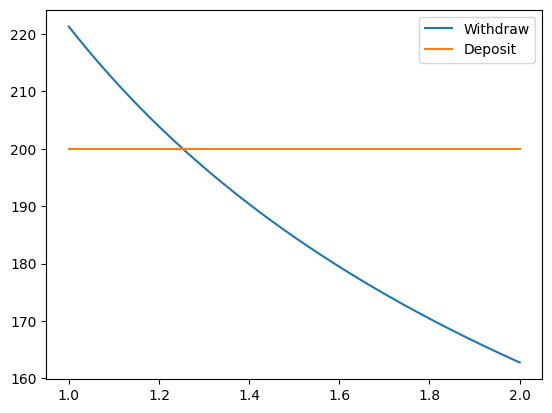

In [ ]:

def Impermanent_loss (Price):
  R_0 = [1000000,1000000]
  R_d = [0,0]
  Result = Init_trade_test_asset0fee(1000,R_0,100000)
  # Big Arb makes the price in CFMM = price in Binance
  Arb = [root(p,price_after_swap) for p in Price]
  output = [swap_fee2(a,R_0[::-1]) for a in Arb]

  # Adjust Result for each output
  Result_list = []
  for out in output:
    temp_result = Result.copy()  # Create a copy of Result
    temp_result[1][0] += out[1]
    Result_list.append(temp_result)

  # Calculate R_1 for each Result
  R_1_list = []
  for i, out in enumerate(output):
    R_1_list.append([new_reserve(R_0.copy(),-out[0],-Arb[i]),Result_list[i][1]])

  # Calculate Withdraw1 and Withdraw2 for each R_1
  Deposit = (1000000*2)*0.0001
  Withdraw1_list = [(r[0][0]*2+r[1][0])*0.0001 for r in R_1_list]
  Withdraw2_list = [(r[0][1]*2+swap_fee1(r[1][0],r[0])[0])*0.0001 for r in R_1_list]

  return [Withdraw1_list,Withdraw2_list]

  # R_0 = [1000000,1000000]
  # output = swap_fee2(Arb,R_0[::-1])
  # Result[1][0] += output[1]
  # R_1 = [new_reserve(R_0,-output[0],-Arb),Result[1]]
  # Deposit = (1000000*2)*0.0001
  # Withdraw1 = (R_1[0][0]*2+R_1[1][0])*0.0001  # value of assets in pool is the same
  # Withdraw2 = (R_1[0][1]*2+swap_fee1(R_1[1][0],R_1[0])[0])*0.0001  # value of assets in pool is the same
  # return [Withdraw1,Withdraw2]

# x = np.linspace(1, 1.5, 100)
# plt.plot(x,Impermanent_loss(x))
# plt.show()
x = np.linspace(1, 2, 100)
# Plot both Withdraw1 and Withdraw2 against x
result = Impermanent_loss(x)
plt.plot(x, result[0], label='Withdraw')
plt.plot(x,[(1000000*2)*0.0001]*len(x),label='Deposit')
# plt.plot(x, result[1], label='Withdraw2')
plt.legend()
plt.show()

#### Traditional case

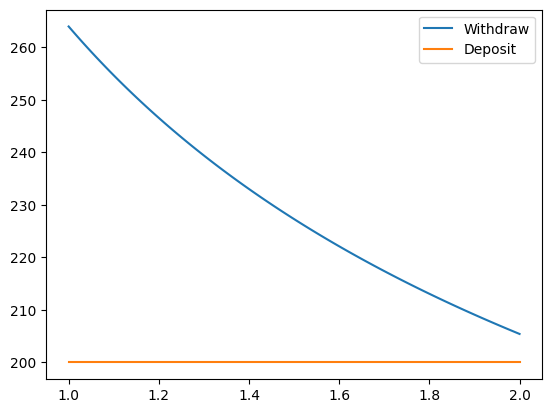

In [ ]:
#test volumn $1,000 back and forth with changing trading reserve.
R_0 =[1000000,1000000]
def Init_traditional_trade(tender_basket,R_0,trade_num):
    for i in range(trade_num):
        y = swap_fee1(tender_basket,R_0)
        R_0 = new_reserve(R_0,tender_basket,y[0]) #y[0]=receive
        x = swap_fee1(y[0],R_0[::-1])
        R_d[0] +=  x[1]
        R_0 = new_reserve(R_0,-x[0],-y[0]) #y[0]=tender
    return [R_0]

def Impermanent_loss_traditional (Price):
  R_0 = [1000000,1000000]
  Result = Init_traditional_trade(1000,R_0,100000)

  # Big Arb makes the price in CFMM = price in Binance
  Arb = [root(p,price_after_swap) for p in Price]
  output = [swap_fee1(a,R_0[::-1]) for a in Arb]

  # Adjust Result for each output
  Result_list = []
  for out in output:
    temp_result = Result.copy()  # Create a copy of Result
    temp_result[0] += out[1]
    Result_list.append(temp_result)

  # Calculate R_1 for each Result
  R_1_list = []
  for i, out in enumerate(output):
    R_1_list.append([new_reserve(R_0.copy(),-out[0],-Arb[i]),Result_list[i][1]])

  # Calculate Withdraw1 and Withdraw2 for each R_1
  Deposit = (1000000*2)*0.0001
  Withdraw1_list = [(r[0][0]*2+r[1][0])*0.0001 for r in R_1_list]
  Withdraw2_list = [(r[0][1]*2+swap_fee1(r[1][0],r[0])[0])*0.0001 for r in R_1_list]

  return [Withdraw1_list,Withdraw2_list]
  # R_0 = [1000000,1000000]
  # output = swap_fee2(Arb,R_0[::-1])
  # Result[1][0] += output[1]

  # R_1 = [new_reserve(R_0,-output[0],-Arb),Result[1]]


  # Deposit = (1000000*2)*0.0001
  # Withdraw1 = (R_1[0][0]*2+R_1[1][0])*0.0001  # value of assets in pool is the same
  # Withdraw2 = (R_1[0][1]*2+swap_fee1(R_1[1][0],R_1[0])[0])*0.0001  # value of assets in pool is the same
  # return [Withdraw1,Withdraw2]

# x = np.linspace(1, 1.5, 100)
# plt.plot(x,Impermanent_loss(x))
# plt.show()
x = np.linspace(1, 2, 100)
# Plot both Withdraw1 and Withdraw2 against x
result = Impermanent_loss(x)
plt.plot(x, result[0], label='Withdraw')
plt.plot(x,[(1000000*2)*0.0001]*len(x),label='Deposit')
# plt.plot(x, result[1], label='Withdraw2')
plt.legend()
plt.show()